## 1. Feature Engineering and Selection

Based on previous feature engineering , we are going to make 2 model that distinguished by have or doesn't have bureau data and we will use features:
- AGE (binned)
- INCOME (binned)
- GENDER
- EDUCATION
- LOAN_PURPOSE
- HAS_APPLIED_BEFORE
- HAS INCOME VERIFICATION
- Bureau data ("LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS")

This notebook will create model for customers with bureau data

# 2. Load library and necessary functions 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, plot_roc_curve, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

In [2]:
# FUNCTIONS TO SPLIT THE DATASETS

import joblib

def split_input_output(dataset,
                       target_column,
                       save_file = True,
                       return_file = True):
    
    output_df = dataset[target_column]
    input_df = dataset.drop([target_column],
                            axis = 1)
    
    if save_file:
        joblib.dump(output_df, "output/output_df.pkl")
        joblib.dump(input_df, "output/input_df.pkl")
    
    if return_file:
        return output_df, input_df


def split_train_test(x, y, TEST_SIZE):
    # Do not forget to stratify if classification
    x_train, x_test,\
        y_train, y_test = train_test_split(x,
                                           y,
                                           test_size=TEST_SIZE,
                                           random_state=123,
                                          stratify=y)

    return x_train, x_test, y_train, y_test

def split_data(data_input, data_ouput, save_file = False, return_file=False, TEST_SIZE=0.2):

    x_train, x_test, \
        y_train, y_test = split_train_test(
            data_input,
            data_ouput,
            TEST_SIZE)

    x_train, x_valid, \
        y_train, y_valid = split_train_test(
            x_train,
            y_train,
            TEST_SIZE)
    
    if save_file:
        joblib.dump(x_train, "output/x_train.pkl")
        joblib.dump(y_train, "output/y_train.pkl")
        joblib.dump(x_valid, "output/x_valid.pkl")
        joblib.dump(y_valid, "output/y_valid.pkl")
        joblib.dump(x_test, "output/x_test.pkl")
        joblib.dump(y_test, "output/y_test.pkl")

    if return_file:
        return x_train, y_train, \
            x_valid, y_valid, \
            x_test, y_test

In [3]:
def binning_features(df):
    #binning Age
    df.loc[ df['AGE'] <= 20, 'AGE'] = 0
    df.loc[(df['AGE'] > 20) & (df['AGE'] <= 34), 'AGE'] = 1
    df.loc[(df['AGE'] > 34) & (df['AGE'] <= 40), 'AGE'] = 2
    df.loc[(df['AGE'] > 40) & (df['AGE'] <= 47), 'AGE'] = 3
    df.loc[ df['AGE'] > 47, 'AGE'] = 4
    
    #income
    df.loc[ df['INCOME'] <= 4e6, 'INCOME'] = 0
    df.loc[(df['INCOME'] > 4e6) & (df['INCOME'] <= 5e6), 'INCOME'] = 1
    df.loc[(df['INCOME'] > 5e6) & (df['INCOME'] <= 6e6), 'INCOME'] = 2
    df.loc[(df['INCOME'] > 6e6) & (df['INCOME'] <= 8e6), 'INCOME'] = 3
    df.loc[(df['INCOME'] > 8e6) & (df['INCOME'] <= 11e6), 'INCOME'] = 4
    df.loc[ df['INCOME'] > 11e6, 'INCOME'] = 5

    return df

In [4]:
def one_hot_encoder(x_cat):
    df = x_cat.copy()
    index = x_cat.index
    col = x_cat.columns
    
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoder.fit(x_cat)

    encoded = encoder.transform(x_cat)
    feat_names = encoder.get_feature_names(col)
    encoded = pd.DataFrame(encoded)
    encoded.index = index
    encoded.columns = feat_names
    return encoded

In [5]:
#compile all engineering
def feature_engineering(df):
    TARGET = "LOAN_WAS_PAID_BACK"
    #drop some features
    df = df.drop(["customer_id", "APPLICATION_RECEIVE_TIME", "KNOWN_ASSETS", "Score"], axis=1)
    #dropna for Income and Loan Purpose
    df = df.dropna(subset = ['INCOME', 'LOAN_PURPOSE'])
    
    #binning
    binning_features(df)
    
    #converting categorical Features
    df['GENDER'] = df['GENDER'].map( {'Male': 1, 'Female': 0} ).astype(int)
    df['HAS_APPLIED_BEFORE'] = df['HAS_APPLIED_BEFORE'].map( {'Yes': 1, 'No': 0} ).astype(int)
    df['HAS_INCOME_VERIFICATION'] = df['HAS_INCOME_VERIFICATION'].map( {'Yes': 1, 'No': 0} ).astype(int)
    
    #one hot encoding
    df_num = df.drop(['EDUCATION','LOAN_PURPOSE'], axis=1)
    df_hot = one_hot_encoder(df[['EDUCATION','LOAN_PURPOSE']])
    df_ready = df_num.join(df_hot)
    
    #split data with or without bureau data
#     df_with_bureau = df_ready.dropna(subset = ['LOANS_WITHOUT_DELAYS', 'LOANS_WITH_DELAYS'])
#     df_without_bureau = df_ready[df_ready['LOANS_WITH_DELAYS'].isna() == True]
#     df_without_bureau = df_ready.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"])
    X_with_bureau = df_ready.drop(columns=TARGET)
    y_with_bureau = df_ready[TARGET]
    
    return X_with_bureau, y_with_bureau

def add_columns(df_raw, df_2):
    df_temp = df_2.copy()
    x_raw, y_raw = feature_engineering(df_raw)
    mis_col = set(x_raw.columns).difference(set(df_2.columns))
    print(mis_col)
    if len(mis_col) > 0:
        for i in mis_col :
            df_temp.loc[:, i] = 0
    else:
        pass
    return df_temp

### Load all our data 

In [6]:
master = pd.read_csv("./Customer_Information.csv")
bureau = pd.read_csv("./Credit_Bureau_Data.csv")
external = pd.read_csv("./External_Score.csv")

# 3. Modelling Start

In this project we are going to handle the imbalance dataset by sampling subsets of the raw data so that the proportion of each of our target class is 50:50. We are going to first filter out all customers without bureau data, taking all customers with label 0 and then randomly sampling the same number of customer with label 1. Then proceed with data splitting and modelling.

### 3.1 Bureau data with 50:50 label sampling

In [7]:
# merge master and bureau and external data
df = pd.merge(master, bureau, on='customer_id', how='left')
df = pd.merge(df, external, on='customer_id', how='left')
df.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score
0,36493,40,10000000.0,Female,Diploma,Working Capital,09:07:00,No,Yes,1,3.0,3.0,40000000.0,0.77
1,36494,39,15000000.0,Female,Bachelor Degree,Other,15:15:00,No,Yes,1,3.0,0.0,20000000.0,0.93
2,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN,NaN,NaN
3,36496,28,4000000.0,Male,Bachelor Degree,Renovation,12:05:00,Yes,Yes,1,2.0,1.0,0.0,0.78
4,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,1.0,0.0,40000000.0,0.81


In [8]:
# get all data with bureau
df_1 = df.dropna(subset = ['LOANS_WITHOUT_DELAYS', 'LOANS_WITH_DELAYS'])

# get all data with label 0
df_2 = df_1.loc[(df_1.LOAN_WAS_PAID_BACK == 0) & (~df_1.LOANS_WITH_DELAYS.isna()), :]

# get all labeled 1 data with the same number of row as label 0 data
df_3 = df_1.loc[df_1.LOAN_WAS_PAID_BACK == 1, :].sample(n = df_2.shape[0])
df_final = pd.concat([df_2, df_3], ignore_index=True)
df_final.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score
0,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,1.0,0.0,40000000.0,0.81
1,36512,40,6000000.0,Female,Bachelor Degree,Working Capital,10:31:00,Yes,Yes,0,4.0,0.0,10000000.0,0.77
2,36526,29,6000000.0,Male,Bachelor Degree,Working Capital,10:35:00,Yes,Yes,0,3.0,2.0,10000000.0,NaN
3,36528,44,10000000.0,Female,Bachelor Degree,Credit card,07:01:00,No,Yes,0,2.0,1.0,NaN,0.77
4,36564,30,13000000.0,Female,Bachelor Degree,Holiday,15:18:00,Yes,Yes,0,1.0,0.0,NaN,NaN


In [9]:
df_final.LOAN_WAS_PAID_BACK.value_counts()

0    761
1    761
Name: LOAN_WAS_PAID_BACK, dtype: int64

### 3.2 train-test-valid split

In [10]:
# do the splitting
TARGET = "LOAN_WAS_PAID_BACK"
TEST_SIZE = 0.3

output_df, input_df = split_input_output(
                            df_final,
                            TARGET, save_file = False)

x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(input_df,
                                                                    output_df,
                                                                    False, # we are not saving to new file, rather using the existing saved pickled files
                                                                   True,
                                                                   TEST_SIZE)

In [11]:
# check if stratify is correct
print(y_train.value_counts(normalize = True))
print("-------------------------------------")
print(y_valid.value_counts(normalize = True))
print("-------------------------------------")
print(y_test.value_counts(normalize = True))

1    0.500671
0    0.499329
Name: LOAN_WAS_PAID_BACK, dtype: float64
-------------------------------------
0    0.5
1    0.5
Name: LOAN_WAS_PAID_BACK, dtype: float64
-------------------------------------
0    0.501094
1    0.498906
Name: LOAN_WAS_PAID_BACK, dtype: float64


### 3.3 Load the preprocess training, validation and testing data  

We are going to used previously pickled datasets which gives the most optimum results

In [12]:
x_train = joblib.load("./output/x_train.pkl")
y_train = joblib.load("./output/y_train.pkl")
x_valid = joblib.load("./output/x_valid.pkl")
y_valid = joblib.load("./output/y_valid.pkl")
x_test = joblib.load("./output/x_test.pkl")
y_test = joblib.load("./output/y_test.pkl")

# 4. Feature preprocessing 

### 4.1 Train engineering 

In [13]:
df_train = pd.concat([x_train, pd.DataFrame(y_train)], axis = 1)

In [14]:
# This is our final feature
X_train_with_bureau, y_train_with_bureau = feature_engineering(df_train)

In [15]:
X_train_with_bureau.columns

Index(['AGE', 'INCOME', 'GENDER', 'HAS_APPLIED_BEFORE',
       'HAS_INCOME_VERIFICATION', 'LOANS_WITHOUT_DELAYS', 'LOANS_WITH_DELAYS',
       'EDUCATION_Bachelor Degree', 'EDUCATION_Diploma',
       'EDUCATION_High School', 'EDUCATION_Master's Degree/Post graduate',
       'EDUCATION_Other', 'LOAN_PURPOSE_Bills', 'LOAN_PURPOSE_Credit card',
       'LOAN_PURPOSE_Education', 'LOAN_PURPOSE_Electronic unsecured loan',
       'LOAN_PURPOSE_Holiday', 'LOAN_PURPOSE_Housing loan',
       'LOAN_PURPOSE_Investment', 'LOAN_PURPOSE_Other',
       'LOAN_PURPOSE_Renovation', 'LOAN_PURPOSE_Venture capital',
       'LOAN_PURPOSE_Working Capital'],
      dtype='object')

In [16]:
# check for missing columns 
X_train_bureau = add_columns(df, X_train_with_bureau)

{'LOAN_PURPOSE_Car/Motorcycle'}


In [17]:
X_train_bureau.shape

(741, 24)

### 4.2 Validation engineering 

In [18]:
df_valid = pd.concat([x_valid, pd.DataFrame(y_valid)], axis = 1)

In [19]:
# This is our final feature
X_valid_with_bureau, y_valid_with_bureau = feature_engineering(df_valid)

In [20]:
X_valid_with_bureau.columns

Index(['AGE', 'INCOME', 'GENDER', 'HAS_APPLIED_BEFORE',
       'HAS_INCOME_VERIFICATION', 'LOANS_WITHOUT_DELAYS', 'LOANS_WITH_DELAYS',
       'EDUCATION_Bachelor Degree', 'EDUCATION_Diploma',
       'EDUCATION_High School', 'EDUCATION_Master's Degree/Post graduate',
       'EDUCATION_Other', 'LOAN_PURPOSE_Bills', 'LOAN_PURPOSE_Credit card',
       'LOAN_PURPOSE_Education', 'LOAN_PURPOSE_Electronic unsecured loan',
       'LOAN_PURPOSE_Holiday', 'LOAN_PURPOSE_Housing loan',
       'LOAN_PURPOSE_Investment', 'LOAN_PURPOSE_Other',
       'LOAN_PURPOSE_Renovation', 'LOAN_PURPOSE_Venture capital',
       'LOAN_PURPOSE_Working Capital'],
      dtype='object')

In [21]:
# check for missing columns 
X_valid_bureau = add_columns(df, X_valid_with_bureau)

{'LOAN_PURPOSE_Car/Motorcycle'}


In [22]:
X_valid_bureau.shape

(320, 24)

### 4.3 Test engineering 

In [23]:
df_test = pd.concat([x_test, pd.DataFrame(y_test)], axis = 1)

# This is our final feature
X_test_with_bureau, y_test_with_bureau = feature_engineering(df_test)

print(X_test_with_bureau.columns)

# check for missing columns 
X_test_bureau = add_columns(df, X_test_with_bureau)

X_test_bureau.shape

Index(['AGE', 'INCOME', 'GENDER', 'HAS_APPLIED_BEFORE',
       'HAS_INCOME_VERIFICATION', 'LOANS_WITHOUT_DELAYS', 'LOANS_WITH_DELAYS',
       'EDUCATION_Bachelor Degree', 'EDUCATION_Diploma',
       'EDUCATION_High School', 'EDUCATION_Master's Degree/Post graduate',
       'EDUCATION_Other', 'LOAN_PURPOSE_Bills', 'LOAN_PURPOSE_Credit card',
       'LOAN_PURPOSE_Education', 'LOAN_PURPOSE_Electronic unsecured loan',
       'LOAN_PURPOSE_Holiday', 'LOAN_PURPOSE_Housing loan',
       'LOAN_PURPOSE_Investment', 'LOAN_PURPOSE_Other',
       'LOAN_PURPOSE_Renovation', 'LOAN_PURPOSE_Venture capital',
       'LOAN_PURPOSE_Working Capital'],
      dtype='object')
{'LOAN_PURPOSE_Car/Motorcycle'}


(454, 24)

# 5. ML training 

In [24]:
from collections import Counter
from sklearn.datasets import make_classification
# from imblearn.over_sampling import SMOTE 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

In [25]:
# Changing everything to float and replacing infinities
for c in X_train_bureau.columns:
    X_train_bureau[c] = X_train_bureau[c].astype(np.float64)
X_train_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [26]:
X_train_bureau.isnull().sum()

AGE                                        0
INCOME                                     0
GENDER                                     0
HAS_APPLIED_BEFORE                         0
HAS_INCOME_VERIFICATION                    0
LOANS_WITHOUT_DELAYS                       0
LOANS_WITH_DELAYS                          0
EDUCATION_Bachelor Degree                  0
EDUCATION_Diploma                          0
EDUCATION_High School                      0
EDUCATION_Master's Degree/Post graduate    0
EDUCATION_Other                            0
LOAN_PURPOSE_Bills                         0
LOAN_PURPOSE_Credit card                   0
LOAN_PURPOSE_Education                     0
LOAN_PURPOSE_Electronic unsecured loan     0
LOAN_PURPOSE_Holiday                       0
LOAN_PURPOSE_Housing loan                  0
LOAN_PURPOSE_Investment                    0
LOAN_PURPOSE_Other                         0
LOAN_PURPOSE_Renovation                    0
LOAN_PURPOSE_Venture capital               0
LOAN_PURPO

In [27]:
# Fixing column names that contains [,],or < for XGBoost model
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_bureau.columns.values]
X_valid_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_valid_bureau.columns.values]
X_test_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test_bureau.columns.values]

### 5.1 Create baseline models 

We are going to start with evaluating baseline on various model with training data , and test the performance on validation data

In [28]:
# Check the baseline model
def baseline_model(X_train,y_train):
  clf_logreg = LogisticRegression().fit(X_train,y_train)
  clf_rf = RandomForestClassifier().fit(X_train,y_train)
  clf_tree = DecisionTreeClassifier().fit(X_train,y_train)
  clf_knn = KNeighborsClassifier().fit(X_train,y_train)
  clf_lgbm = LGBMClassifier().fit(X_train,y_train)
  clf_xgb = xgb.XGBClassifier().fit(X_train,y_train)

  gini_logreg = (2*(roc_auc_score(y_train, clf_logreg.predict_proba(X_train)[:, 1])))-1
  gini_rf = (2*(roc_auc_score(y_train, clf_rf.predict_proba(X_train)[:, 1])))-1
  gini_tree = (2*(roc_auc_score(y_train, clf_tree.predict_proba(X_train)[:, 1])))-1
  gini_knn = (2*(roc_auc_score(y_train, clf_knn.predict_proba(X_train)[:, 1])))-1
  gini_lgbm = (2*(roc_auc_score(y_train, clf_lgbm.predict_proba(X_train)[:, 1])))-1
  gini_xgb = (2*(roc_auc_score(y_train, clf_xgb.predict_proba(X_train)[:, 1])))-1

  print("Gini Performance Evaluation\n")
  print(f"Logistic Regression Gini : {gini_logreg}")
  print(f"Random Forest Gini       : {gini_rf}")
  print(f"Decision Tree Gini       : {gini_tree}")
  print(f"KNN Classifier Gini      : {gini_knn}")
  print(f"LGBM Gini                : {gini_lgbm}")
  print(f"XGBoost Gini             : {gini_xgb}")

  return clf_logreg, clf_rf, clf_tree, clf_knn, clf_lgbm, clf_xgb
 
clf_logreg, clf_rf, clf_tree, clf_knn, clf_lgbm, clf_xgb = baseline_model(X_train_bureau,y_train_with_bureau)

[23:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Gini Performance Evaluation

Logistic Regression Gini : 0.3611422743498216
Random Forest Gini       : 0.9800393385299047
Decision Tree Gini       : 0.9848328112479054
KNN Classifier Gini      : 0.5990602462300574
LGBM Gini                : 0.8263349602972245
XGBoost Gini             : 0.9292926349530124


### 5.2 Hyperparameter tuning on best baseline model

Taking top 3 models based on the training gini

In [29]:
%%time

clf_xgb = xgb.XGBClassifier()
clf_tree = DecisionTreeClassifier()
clf_rf = RandomForestClassifier()

# Define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=69)

# Define search space
space_tree = dict()
space_rf = dict()
space_xgb = [
  {
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
#     'fs__score_func': [chi2],
    'fs__k': [10],
  }
]

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] #RF
max_depth.append(None) #RF
space_rf['max_depth'] = max_depth # RF
space_rf['min_samples_split'] = [2, 5, 10] # RF
space_rf['min_samples_leaf'] = [1, 2, 4] # RF

space_tree['max_depth'] = [2, 3, 5, 10, 20] #DT
space_tree['min_samples_leaf'] = [5, 10, 20, 50, 100] #DT
space_tree['criterion'] = ["gini", "entropy"] #DT

# Define search
search_tree = RandomizedSearchCV(clf_tree, space_tree, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=69)
search_rf = RandomizedSearchCV(clf_rf, space_rf, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=69)
search_xgb = RandomizedSearchCV(clf_xgb, space_xgb, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=69)

# Execute search
result_tree = search_tree.fit(X_train_bureau, y_train_with_bureau)
result_rf = search_rf.fit(X_train_bureau, y_train_with_bureau)
result_xgb = search_xgb.fit(X_train_bureau, y_train_with_bureau)

# Summarize result
print('Best Score tree: %s' % ((result_tree.best_score_ * 2) - 1))
print('Best Hyperparameters: %s' % result_tree.best_params_)

print('Best Score rf: %s' % ((result_rf.best_score_*2) - 1))
print('Best Hyperparameters: %s' % result_rf.best_params_)

print('Best Score xgb: %s' % ((result_xgb.best_score_*2) - 1))
print('Best Hyperparameters: %s' % result_xgb.best_params_)


[23:37:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:37:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Score tree: 0.21108281111837313
Best Hyperparameters: {'min_samples_leaf': 100, 'max_depth': 10, 'criterion': 'gini'}
Best Score rf: 0.2793471992618508
Best Hyperparameter

### 5.3 Evaluate on validation data 

In [30]:
dt_valid = DecisionTreeClassifier(
    min_samples_leaf = 100, 
    max_depth = 10, 
    criterion = 'gini').fit(X_train_bureau,y_train_with_bureau)

rf_valid = RandomForestClassifier(
    min_samples_split = 2, 
    min_samples_leaf = 4, 
    max_depth = 10).fit(X_train_bureau,y_train_with_bureau)

xgb_valid = xgb.XGBClassifier(
    fs__k= 10, 
    n_estimators= 50, 
    max_depth= 3, 
    learning_rate= 0.01, 
    gamma= 0.2, 
    colsample_bytree= 0.2,
    verbosity = 0).fit(X_train_bureau,y_train_with_bureau)

def gini_value(x, y, model):
    return (2*(roc_auc_score(y, model.predict_proba(x)[:, 1])))-1

print("GINI validation data for Decision Tree :" , gini_value(X_valid_bureau, y_valid_with_bureau, dt_valid))
print("GINI validation data for Random Forest :" , gini_value(X_valid_bureau, y_valid_with_bureau, rf_valid))
print("GINI validation data for XGBOOST :" , gini_value(X_valid_bureau, y_valid_with_bureau, xgb_valid))

GINI validation data for Decision Tree : 0.22316406249999998
GINI validation data for Random Forest : 0.2401171875000001
GINI validation data for XGBOOST : 0.29011718749999993


Using Xgboost model since it provide highest gini in validation data

In [31]:
from sklearn.metrics import classification_report

y_pred_valid = xgb_valid.predict(X_valid_bureau)

print(classification_report(y_valid_with_bureau, y_pred_valid))

              precision    recall  f1-score   support

           0       0.60      0.63      0.61       160
           1       0.61      0.57      0.59       160

    accuracy                           0.60       320
   macro avg       0.60      0.60      0.60       320
weighted avg       0.60      0.60      0.60       320



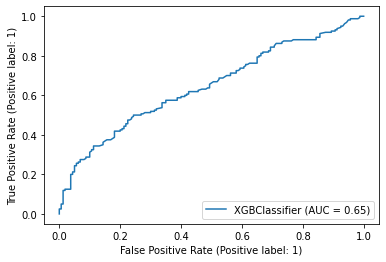

In [32]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(xgb_valid,X_valid_bureau,y_valid_with_bureau)
plt.show()

### 5.4 Retrain model with combined validation and train data 

We are going to retrain the model with combination of our validation and training data, then test the performance against our test dataset

In [33]:
# combine validation and train data
x_combine = pd.concat([X_train_bureau, X_valid_bureau]).reset_index(drop = True)
y_combine = pd.concat([y_train_with_bureau, y_valid_with_bureau]).reset_index(drop = True)

xgb_retrain = xgb.XGBClassifier(
    fs__k= 10, 
    n_estimators= 50, 
    max_depth= 3, 
    learning_rate= 0.01, 
    gamma= 0.2, 
    colsample_bytree= 0.2,
    verbosity = 0).fit(x_combine,y_combine)

# rf_retrain = RandomForestClassifier(
#     min_samples_split = 5, 
#     min_samples_leaf = 4, 
#     max_depth = 80).fit(x_combine,y_combine)

# dt_retrain = DecisionTreeClassifier(
#     min_samples_leaf = 50, 
#     max_depth = 3, 
#     criterion = 'gini').fit(x_combine,y_combine)

print("GINI validation combine for XGBOOST :" , gini_value(x_combine, y_combine, xgb_retrain))

GINI validation combine for XGBOOST : 0.3684646270831111


In [34]:
from sklearn.metrics import classification_report

y_pred_comb = xgb_retrain.predict(x_combine)

print(classification_report(y_combine, y_pred_comb))

              precision    recall  f1-score   support

           0       0.63      0.69      0.66       531
           1       0.66      0.59      0.62       530

    accuracy                           0.64      1061
   macro avg       0.64      0.64      0.64      1061
weighted avg       0.64      0.64      0.64      1061



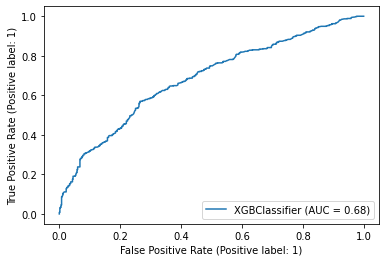

In [35]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(xgb_retrain, x_combine, y_combine)
plt.show()

# 6. Evaluate Model Performance  

### 6.1 Test model performance on testing dataset  

We now test the model on our hold out (test) dataset

In [79]:
y_pred_test = xgb_retrain.predict(X_test_bureau)

print(classification_report(y_test_with_bureau, y_pred_test))

print("GINI test for retrain XGBOOST :" , gini_value(X_test_bureau, y_test_with_bureau, xgb_retrain))

              precision    recall  f1-score   support

           0       0.55      0.62      0.58       228
           1       0.56      0.49      0.52       226

    accuracy                           0.56       454
   macro avg       0.56      0.55      0.55       454
weighted avg       0.56      0.56      0.55       454

GINI test for retrain XGBOOST : 0.2045101692283806


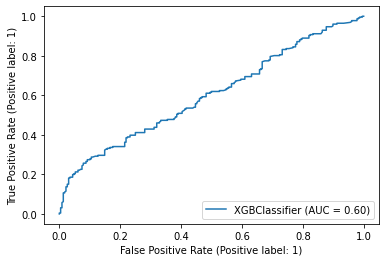

In [80]:
plot_roc_curve(xgb_retrain, X_test_bureau,y_test_with_bureau)
plt.show()

### 6.2 Decile Analysis

In order to minimise the risk, we are going to rank customer based on their predicted probability of paying back their loan through decile analysis, and then set a threshold of which rank we will accept for a loan

In [81]:
y_pred_test_prob = xgb_retrain.predict_proba(X_test_bureau)
df_decile=X_test_bureau.copy()
df_decile['proba']=y_pred_test_prob[:,1]
df_decile['act']=y_test_with_bureau
df_decile.sort_values(by=['proba'], ascending=True, inplace=True)
df_decile.head()

,AGE,INCOME,GENDER,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,EDUCATION_Bachelor Degree,EDUCATION_Diploma,EDUCATION_High School,...,LOAN_PURPOSE_Holiday,LOAN_PURPOSE_Housing loan,LOAN_PURPOSE_Investment,LOAN_PURPOSE_Other,LOAN_PURPOSE_Renovation,LOAN_PURPOSE_Venture capital,LOAN_PURPOSE_Working Capital,LOAN_PURPOSE_Car/Motorcycle,proba,act
255,1,2.0,0,1,0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.450833,0
1217,1,0.0,0,1,0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.453011,1
112,1,0.0,0,1,0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.455686,0
197,4,4.0,0,1,0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.456087,0
1294,3,2.0,0,1,0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.457448,1


In [82]:
df_decile.reset_index(inplace=True)
del df_decile['index']
df_decile.reset_index(inplace=True)

In [83]:
df_decile['decile']=pd.cut(df_decile['index'],10,labels=False,duplicates='drop')+1
df_decile.head()

,index,AGE,INCOME,GENDER,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,EDUCATION_Bachelor Degree,EDUCATION_Diploma,...,LOAN_PURPOSE_Housing loan,LOAN_PURPOSE_Investment,LOAN_PURPOSE_Other,LOAN_PURPOSE_Renovation,LOAN_PURPOSE_Venture capital,LOAN_PURPOSE_Working Capital,LOAN_PURPOSE_Car/Motorcycle,proba,act,decile
0,0,1,2.0,0,1,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0.450833,0,1
1,1,1,0.0,0,1,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.453011,1,1
2,2,1,0.0,0,1,0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0.455686,0,1
3,3,4,4.0,0,1,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0.456087,0,1
4,4,3,2.0,0,1,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.457448,1,1


In [84]:
df_decile[['index','act']].groupby(['act']).count()

,index
act,
0,228
1,226


In [85]:
df_decile_2=df_decile.groupby(['decile','act'],as_index=True)[['index']].count().sort_values(by=['decile','act'], ascending=True)
pd.DataFrame(df_decile_2.groupby("act")['index'].agg("cumsum"))

index
decile act       
1      0       30
       1       16
2      0       55
       1       36
3      0       76
       1       60
4      0      101
       1       81
5      0      126
       1      101
6      0      152
       1      120
7      0      178
       1      140
8      0      202
       1      161
9      0      221
       1      187
10     0      228
       1      226

We can see that our model can predict 55% (126/228) of the default customer from top 5 decile. We can then set a threshold that each customers we scored who fall on or below this 5th decile will be rejected for a loan.

Below we will compute the probabilty range for each customer and set the threshold accordingly

In [86]:
df_decile_3=df_decile[['decile','proba']].groupby(['decile'],as_index=True)[['proba']].min().sort_values(by=['decile'], ascending=True)
df_decile_3.rename(columns={'proba':'min_proba'},inplace=True)
df_decile_3['max_proba']=df_decile[['decile','proba']].groupby(['decile'],as_index=True)[['proba']].max().sort_values(by=['decile'], ascending=True)
df_decile_3.head(20)

,min_proba,max_proba
decile,,
1,0.450833,0.479557
2,0.479745,0.485999
3,0.485999,0.489698
4,0.489860,0.492713
5,0.492805,0.498027
6,0.498065,0.501172
7,0.501195,0.506379
8,0.506432,0.511936
9,0.511936,0.521339


We will our probabilty of paying back threshold at 0.498

### 6.3 Performance on all data with bureau 

Finally, we will test how the model perform in predicting probability of paying back their loan agains all the data that we have 

In [88]:
df_1.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score
0,36493,40,10000000.0,Female,Diploma,Working Capital,09:07:00,No,Yes,1,3.0,3.0,40000000.0,0.77
1,36494,39,15000000.0,Female,Bachelor Degree,Other,15:15:00,No,Yes,1,3.0,0.0,20000000.0,0.93
3,36496,28,4000000.0,Male,Bachelor Degree,Renovation,12:05:00,Yes,Yes,1,2.0,1.0,0.0,0.78
4,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,1.0,0.0,40000000.0,0.81
5,36498,47,8000000.0,Female,Master's Degree/Post graduate,Renovation,02:47:00,No,Yes,1,7.0,0.0,NaN,0.78


In [89]:
x_all, y_all = feature_engineering(df_1)

In [90]:
# Changing everything to float and replacing infinities
for c in x_all.columns:
    x_all[c] = x_all[c].astype(np.float64)
x_all.replace([np.inf, -np.inf], np.nan, inplace=True)

x_all.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_all.columns.values]

### performance

In [91]:
y_pred = xgb_retrain.predict(x_all)

print(classification_report(y_all, y_pred))

print("GINI all data for retrain XGBOOST :" , gini_value(x_all, y_all, xgb_retrain))

              precision    recall  f1-score   support

           0       0.21      0.51      0.30       759
           1       0.89      0.68      0.77      4470

    accuracy                           0.65      5229
   macro avg       0.55      0.59      0.53      5229
weighted avg       0.79      0.65      0.70      5229

GINI all data for retrain XGBOOST : 0.26871545923194606


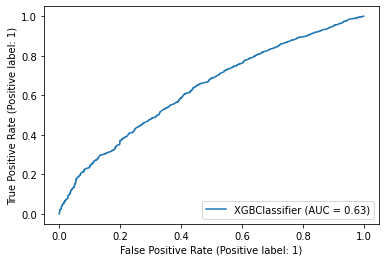

In [92]:
plot_roc_curve(xgb_retrain, x_all, y_all)
plt.show()

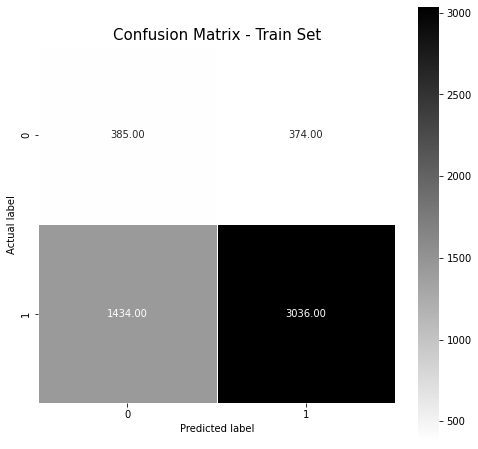

In [93]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_all, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square =True, cmap = 'binary');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Confusion Matrix - Train Set'
plt.title(all_sample_title, size = 15)
plt.show()

### 6.4 Save the model for serving

In [94]:
joblib.dump(xgb_retrain, "output/xgb_retrain_bureau.pkl")

['output/xgb_retrain_bureau.pkl']

In [95]:
c = joblib.load("output/xgb_retrain_bureau.pkl")

In [96]:
c.predict(x_all.iloc[[0],:])[0]

1